==============================================================================================
# Practicum 6 

==============================================================================================

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **english**.

- The deliverable must be a file named **P6_Student1_Student2.zip** that includes:
    - The notebook P6_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    - All the images used in this notebook.

**Deadline: December 22th, 23:00 h**

==============================================================================================

## Imports

In [5]:
from time import time
import os

import numpy as np
from numpy import unique
import matplotlib.pyplot as plt

import skimage
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage import io

# Split dataset into training and test
from sklearn.model_selection import train_test_split 

### FACE DETECTION
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature
from skimage.transform import integral_image

### FACE RECOGNITION
# Load the dataset
from sklearn.datasets import fetch_lfw_people 
# Classification and results
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report 

# others imports
from skimage.io import imread
import random
from skimage.transform import integral_image
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance

In [6]:
def show_img(image,title):
    """
    function that displays a single image with its corresponding title
        image: image we want to display
        title: title of the image we want to display
    """
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [7]:
def show_images(images,titles,ncols):
    """
    function that displays a set of images
        images: list of images
        titles: list of image titles
        ncols: number of columns
    """
    nrows = len(images)//ncols
    
    if nrows == 1:
        show_row_of_images(images,titles)
    
    elif ncols == 1:
        for i in range(len(images)):
            show_img(images[i],titles[i])
    else:
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(15,10))

        index = 0
        for i in range(nrows):
            for j in range(ncols):
                ax = axs[i,j]
                ax.imshow(images[index],cmap='gray')
                ax.set_title(titles[index])
                ax.axis('off')
                index += 1

        plt.show()

In [8]:
def show_row_of_images(images,titles):
    """
    function that displays a row of images
        images: list of images
        titles: list of image titles
    """
    canvas, axs = plt.subplots(nrows=1, ncols=len(images), figsize=(10,5))
    
    for index,image in enumerate(images):
        ax = axs[index]
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        ax.set_title(titles[index])
    plt.show()

==============================================================================================
## Haar-like features applied for face detection
==============================================================================================

### What is a Haar-like feature?

Haar-like feature descriptors were successfully used to implement the first real-time face detector. In this laboratory we will see an example illustrating the extraction, selection, and classification of Haar-like features to detect faces vs. non-faces.

Documentation [Haar-like feature skimage](https://scikit-image.org/docs/0.14.x/auto_examples/xx_applications/plot_haar_extraction_selection_classification.html)

Haar-like features are features extracted from the images to recognize objects. These features are normally used in face recognition. The key to face recognition is to detect the relevant features of humans such as eyes, lips, or nose. 


<img src="notebook_images/haar-like.PNG" width=400, height=400>

Try to guess where in the face image we expect to detect an edge, line or another facial feature and what would be the most appropriate Haar-feature for them? 

<img src="notebook_images/haar-like1.PNG" width=500, height=500>


A real application would be:

<img src="notebook_images/face.PNG" width=300, height=300>


To describe the face, we can apply convolutions with Haar features. What alternative to the convolution with Haar-features, do you know?


### 1. Building integral image

Compute all the Haar-like features (we can define up to 16000 million masks), can be a slow process. To compute it faster, we are going to use the integral images (instead of convolutions). It is very useful because we are able to save all the sums and substrations of image rectangles to avoid computing all the features every time.

When creating an Integral Image, we need to create a Summed Area Table. What does represent any point (x,y) in this table?

<img src="notebook_images/integral_image.PNG" width=250, height=2500>

An example :

<img src="notebook_images/integral_image1.PNG" width=400, height=400>

To easy the computation of Haar features, the integral image must have an additional row and column full of zeros (first row and first column). Why?

**1.1** Build a function `to_integral_image` that computes the integral image of an input (2D) array. The integral image must have an additional row and column full of zeros (first row and first column).
Make sure that the values of the integral image are correct.

Try your function using a `5x5` random grayscale image. Visualize both the original random image and the integral one.

[[0.24100386 0.02587693 0.63944165 0.46252962 0.00507855]
 [0.89624434 0.09197772 0.33241317 0.95909349 0.6534698 ]
 [0.7604794  0.89791781 0.89805945 0.36539588 0.44920127]
 [0.38524756 0.72019929 0.13526766 0.75820711 0.41791731]
 [0.11663797 0.8816873  0.77398274 0.70857737 0.51819841]]


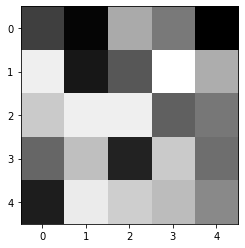

In [9]:
# Define a 5x5 random grayscale image and visualize it
img_array = np.random.rand(5,5)
plt.imshow(img_array, cmap='gray')
print(img_array)

In [10]:
def to_integral_image(im):
    '''
    function that return the integral image of a 2D arrar (in image, means grayscale image)
        im: input 2D array
    return the integral image of the input array
    '''
    # Additional first row and column with zeros
    integral_image = np.zeros((im.shape[0]+1, im.shape[1]+1))
    
    # We sum all the values from all above and right of the array
    for i in range(im.shape[0]+1):
        for j in range(im.shape[1]+1):
            integral_image[i,j] = np.sum(im[:i,:j])
            
    return integral_image

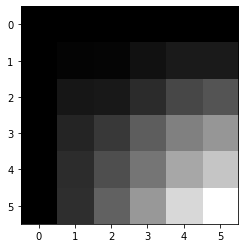

In [11]:
# Applying the funtion to the random 5x5 array
ii_img_array = to_integral_image(img_array)

# Plot it with axis, as we can see is one columne and row more
plt.imshow(ii_img_array, cmap='gray')

To make sure that the values of the integral image are correct, compute the following tests:

 - `img_array.sum() == ii_img_array[-1,-1]`
 - `img_array[0,:].sum() == ii_img_array[1,-1]`

In [12]:
# Testing our results
# 1. First we test if the total of the integral image is the same as the last number (because it sum all the elements)
assert img_array.sum() == ii_img_array[-1,-1], "to_integral_image test failed"
# 2. Second we are testing the total of just one row, if the sum of the first row is the same as the last element of the original array
# Remember we add a new row and column
assert img_array[0,:].sum() == ii_img_array[1,-1], "to_integral_image test failed"

**1.2** Let's check in real images. Choose an image from the directory ``./faces``, visualize both the original and the integral image, and make the same test that in the previous question.

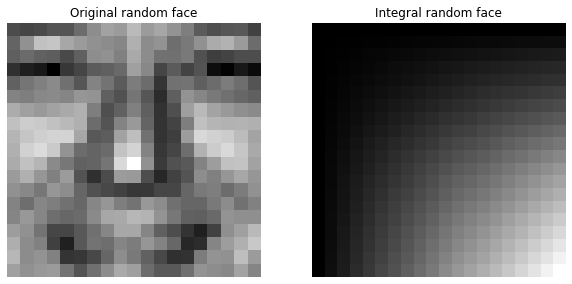

In [13]:
# We create the faces directory
directory_faces = './faces/'
face_images = [imread(os.path.join(directory_faces, filename)) for filename in os.listdir(directory_faces)]

# Choose a rondom image and create the integral image
random_face = face_images[random.randrange(len(face_images))]
integral_random_face = to_integral_image(random_face)

# Show them
show_images([random_face,integral_random_face],['Original random face','Integral random face'],2)

What do the following lines mean? How can you explain this?

- `img_array.sum() == ii_img_array[-1,-1]`: Here we test if the total sum of the array is the same as the last one element (value), because one element keeps the sum of the elements it has on the left and above. That means the last element keeps the sum of all the matrix.
- `img_array[0,:].sum() == ii_img_array[1,-1]`: We just test for onw row, the sum of the whole row needs to be the value of the last element of the row, because sum of alls elements on the left.
- `ii_img_array[0,-1].sum() == 0`: Here we just take the last element from the first row, which is 0 because from the exercise we add a new row and column by zeros.
 

In [14]:
# Test all 3 points for the new image
assert random_face.sum() == integral_random_face[-1,-1], "test 1 failed"
assert random_face[0,:].sum() == integral_random_face[1,-1], "test 2 failed"
assert integral_random_face[0,-1] == 0, "test 3 failed"

**1.3:** Alternatively to your own function, you can use the ``integral_image()`` function from ``skimage.transform``. Compare (numerically) the result obtained using your funtion and that obtained using the function provided by skimage.

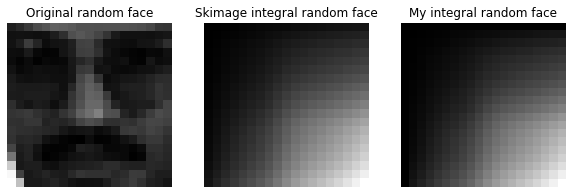

1. All sum compared with skimage function: True
2. First row compared with skimage function: True


In [15]:
# Using another random face we can test the function from skimage
random_face = face_images[random.randrange(len(face_images))]
my_integral_random_face = to_integral_image(random_face)
integral_random_face = integral_image(random_face)

show_images([random_face,integral_random_face,my_integral_random_face],['Original random face','Skimage integral random face','My integral random face'],3)

# Test with function from skimage, that one uses dype: uint64, if necessary we need to make convertion to float for our integral image
# In that case is the same, because the random face uses uint8
print("1. All sum compared with skimage function:", my_integral_random_face.sum() == integral_random_face.sum())
# Remember our integral image as one row and column more than the skimage integral one
print("2. First row compared with skimage function:", my_integral_random_face[1,:].sum() == integral_random_face[0,:].sum())


## 2. Haar-like features

Let's use the [haar_like_feature()](https://scikit-image.org/docs/0.14.x/api/skimage.feature.html#skimage.feature.haar_like_feature) function from skimage. Check the parameters and the returned value of the ``function haar_like_feature()`` before continuing and **NOTE** that we must use the integral image (**not the real image**) in this function.

*skimage.feature.haar_like_feature(int_image, rint, cint, widthint, heightint, feature_type=None, feature_coord=None)*



###  Extract features

**2.1** Define a function ``extract_feature_image(image, feature_type, feature_coord=None)`` to obtain the Haar-like features, using a given type of features ``feature_types``, from an image. The aim of this function is as simple as to join both `to_integral_image()` and `haar_like_feature()`functions.

Try your function using the choosing image from *1.4*. You should obtain a feature vector. Print the vector shape.

**Note:** You can give an array with a set of feature types to the `haar_like_feature()` function and it will compute all the corresponding features. We **do not** need to give each time only one feature.


In [16]:
feature_types = ['type-2-x', 'type-2-y',
                 'type-3-x', 'type-3-y',
                 'type-4']

In [17]:
def extract_feature_image(image, feature_types, feature_coord=None):
    '''
    function to extract the haar like features from a image
        image: input array we compute the extraction
        feature_type: list of features we want to found in the input
    return a feature extracted array
    '''
    # First we need to compute the integral image, cause the haar_like_feature function needs it
    integral_image = to_integral_image(image)
    # Now using the skimage function to get the feature vector
    feature = haar_like_feature(integral_image, 0, 0, integral_image.shape[0], integral_image.shape[1], feature_type=feature_types, feature_coord=feature_coord)
   
    return feature


In [18]:
# We try the function on one image from faces
random_face = face_images[random.randrange(len(face_images))]
feature_random_face = extract_feature_image(random_face, feature_types)

# We print the feature and the its shape
print("Random face feature vector: ", feature_random_face)
print("Shape of the face feature vector: ", feature_random_face.shape)

Random face feature vector:  [  0.   0.   0. ... -28. -15.  -3.]
Shape of the face feature vector:  (78134,)


**2.2** Plot a Haar-like feature on an image:

To visualize Haar-like features on an image, we need the fuctions, provided by skimage, ``haar_like_feature_coord()``, which computes the coordinates of Haar-like features, and ``draw_haar_like_feature()``, used to visualize that features.

Before continuing, please, **check the online documentation of the two functions**

- [*haar_like_feature_coord(width, height, feature_type=None)*](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.haar_like_feature_coord)

- [*draw_haar_like_feature(image, r, c, width, height, feature_coord, color_positive_block=(1.0, 0.0, 0.0), color_negative_block=(0.0, 1.0, 0.0), alpha=0.5, max_n_features=None, random_state=None)*](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.draw_haar_like_feature)

Define a function ``plotFeatures``  to visualize Haar-like features on an images, given a array of feature types ``feature_types``. The aim of this exercise is, similarly to the previous one, to merge both `haar_like_feature_coord()` and `draw_haar_like_feature()` functions. Try your own function using the choosing image from *1.4* as follows:

<img src="notebook_images/image1.png" width=600, height=300>

In [19]:
def plotFeatures(image, feature_types, feature_coord=None):
    '''
    function for plot the haar like features in a original image input
        image: input array image
        feture_types: list of type of feature we have and use
    '''
    images = []
    print('The differents Haar-like feature descriptors')
    for feat_t in feature_types:
        # Computes the coordinates of Haar-like features
        coord, _ = haar_like_feature_coord(image.shape[0], image.shape[1], feat_t)
        # If we don't use random_state the size and position of the feature will be random: random_state = 0
        img = draw_haar_like_feature(image, 0, 0, image.shape[0], image.shape[1], coord, max_n_features=1)
        images.append(img)
        
    # Show all features extracted using a function before declared
    show_images(images, feature_types, len(feature_types))

The differents Haar-like feature descriptors


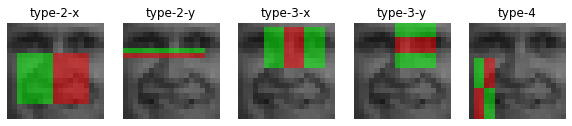

In [20]:
# Obtain a random face
random_face = face_images[random.randrange(len(face_images))]

# Use the defined function for plot
plotFeatures(random_face,feature_types)

## 3 Face detection using an Adaboost

**3.1** Read all the images from the directories ``./faces`` and ``./nonfaces`` and build an array with the all the features. 

Futhermore, build the class labels vector ``y`` with the label of all the images

In [31]:
# First we create the directories
directory_faces = './faces/'
face_images = [imread(os.path.join(directory_faces, filename)) for filename in os.listdir(directory_faces)]
directory_nonfaces = './nonfaces/'
nonface_images = [imread(os.path.join(directory_nonfaces, filename)) for filename in os.listdir(directory_nonfaces)]

**3.2** Using the ``train_test_split()`` function from `sklearn.model_selection`, divide the dataset into *train* and *test* sets. The test size must be the 30% (i.e. 0.3) of the whole dataset.

[*sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [32]:
# Join all images and extract for each one the features
all_images = face_images + nonface_images
features = [extract_feature_image(img, feature_types) for img in all_images]

In [33]:
# For label all images: 0 is type face and 1 es type no face
y = np.concatenate([np.zeros(len(face_images), dtype=int), np.ones(len(nonface_images), dtype=int)])
y_names = ["Face", "No face"]

In [34]:
y = range(len(all_images))

In [35]:
from sklearn.model_selection import train_test_split

# Use the sklearn function to divide in TRAIN and TEST datasets. TRAIN*0.7 + TEST*0.3 = TOTAL
features_train, features_test, y_train, y_test = train_test_split(features, y, test_size=0.3)

# We can also add random_state if we want a random set of datas

**3.3** Train an Adaboost classifier using `AdaBoostClassifier()`from `sklearn.ensemble`.

[*sklearn.ensemble.AdaBoostClassifier(n_estimators=50, learning_rate=1.0)*](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

What is an Adaboost? How it works?

In [36]:
from sklearn.ensemble import AdaBoostClassifier

# Using function from skimage
clf = AdaBoostClassifier(n_estimators=50, learning_rate=1.0)

What is an Adaboost? How it works?
> Adaboost, from Adaptive and Boosting, is a meta-learning algorithm or method for mainly classification tasks. Mostly used by binary results. It joins several weak classifiers , such as decision trees, to to form a stronger one. You start by creating a model from the training data. Then, you create a second model from the previous one by trying to reduce the errors from the previous model. The iteration continues, and models are added sequentially, each correcting its predecessor, until the training data is predicted perfectly or the maximum number of models have been added.

**3.4** Evaluate the accuracy of the Adaboost classifier using the *predict* and *score* methods of the classifier. What are these methods doing?

In [37]:
def evaluate(clf,X,y,X_test,y_test):
    '''
    function that evaluates the accuracy of the classifier
        clf: classifier
        X: training data 
        y: labels of X
        X_test: data for testing
        y_test: labels of test data set
    '''
    clf.fit(X,y)
    clf.predict(X_test)
    
    return clf.score(X_test, y_test, sample_weight=None)

In [28]:
print("Accuracy of train set: ", evaluate(clf,features_train,y_train,features_test,y_test))

Accuracy of train set:  0.9523809523809523


In [29]:
print(len(features_train))
print(len(features_train[0]))

47
78134


Change the parameter ``n_estimators`` and see what happens. Does it improve?

In [30]:
# Now we change the n_estimators for more iteration
clf2 = AdaBoostClassifier(n_estimators=120, learning_rate=0.5)
print("Accuracy of train set: ", evaluate(clf2,features_train,y_train,features_test,y_test))

Accuracy of train set:  1.0


> For larger n_estimators, larger number of weak learnes, so we can adjust that parameter to optimize the result, and in that case, it actually have improved. But costs more time.

**3.5** The method ``feature_importances_`` of the Adaboost is giving the importance of the features. Implement a function to visualize the 10 most important features on an image of a face on your choice. 

In [44]:
# Recover the original classifier
clf = AdaBoostClassifier()
clf.fit(features_train, y_train)
# Use AdaboostClassifier function to get the importance of each feature
feature_importance = clf.feature_importances_

In [45]:
# Get the 10 most important features, that means the 10 larger values from the feature_importance
indices = np.argsort(feature_importance)[::-1][:10]
print("The 10 most important feature indices:",indices)
print("The values are:", feature_importance[indices])

The 10 most important feature indices: [73640  5028  4632 46415 43759 34510 71765 23013 19386 43370]
The values are: [0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02]


[73640  5028  4632 46415 43759 34510 71765 23013 19386 43370]


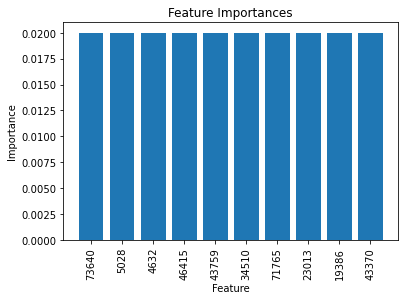

In [46]:
def plot_important_features(model, X, y):
    # get the 10 most important features
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    print(indices)
    # get the feature names
    feature_names = [i for i in indices]

    # create a bar chart to visualize the importance of the features
    plt.bar(range(10), importances[indices], align='center')
    plt.xticks(range(10), feature_names, rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.title("Feature Importances")
    plt.show()


# fit the AdaBoost model and plot the important features
plot_important_features(clf, features_train, y_train)

In [47]:
# Visualize the top 10 most important features on a face
'''For that exercise we need to recover that represent each 10 most important features, looking for the type of 
the feature and the size (scale)'''

'For that exercise we need to recover that represent each 10 most important features, looking for the type of \nthe feature and the size (scale)'

**3.6 (Optional)** Implement the Adaboost training the model using a different number of features. For instace,  just using 1 type of feature, 2 types, and 3 types. Plot the results comparing the precision. Draw conclusions about the results

In [48]:
y1 = np.concatenate([np.zeros(len(face_images), dtype=int), np.ones(len(nonface_images), dtype=int)])
y1_names = ["Face", "No face"]

In [50]:
# For 1 type of feature
features1 = [extract_feature_image(img,'type-2-x') for img in all_images]
classifier1 = AdaBoostClassifier()
features_train1, features_test1, y_train1, y_test1 = train_test_split(features1, y1, test_size=0.3)

print("Accuracy of train set 1: ", evaluate(classifier1,features_train1,y_train1,features_test1,y_test1))

Accuracy of train set 1:  0.9047619047619048


In [52]:
# For 2 types of feature
features2 = [extract_feature_image(img,['type-2-x','type-3-x']) for img in all_images]
classifier2 = AdaBoostClassifier()
features_train2, features_test2, y_train2, y_test2 = train_test_split(features2, y1, test_size=0.4)

print("Accuracy of train set 2: ", evaluate(classifier2,features_train2,y_train2,features_test2,y_test2))

Accuracy of train set 2:  0.7857142857142857


In [53]:
# For 3 types of feature
features3 = [extract_feature_image(img,['type-2-x','type-3-y','type-4']) for img in all_images]
classifier3 = AdaBoostClassifier()
features_train3, features_test3, y_train3, y_test3 = train_test_split(features3, y1, test_size=0.5)

print("Accuracy of train set 3: ", evaluate(classifier3,features_train3,y_train3,features_test3,y_test3))

Accuracy of train set 3:  0.8529411764705882


==============================================================================================
## Principal Component Analysis (PCA) applied for face recognition
==============================================================================================

### Dimensionality and redundancy

Imagine we have a dataset with 100x100 pixel images, it means we have 10000 dimensions. We want to construct a low-dimensional linear subspace that best explains the variation in the set of face images (**Eigenfaces space**)

<img src="notebook_images/subspace.PNG" width=200, height=200>

Each image has m rows and n columns and defines a vector of (mxn) elements. We need to choose the most valuable pixels in order to avoid compute all dimensions. 

<img src="notebook_images/feature_vector.PNG" width=800, height=400>

We look for a transformation of the original space to a smaller (M << (mxn)) where faces are represented with their coordinates in this new space R.

To reduce the dimensionality retaining the information necessary to classify and recognize, we are going to use the **Eigenfaces method** 

### How to build a reduced space?

To build this new space, we are going to use the **Principal Component Analysis**. Given a large space, the PCA looks for the minimum number of axes that best represents the variation of the data.

<img src="notebook_images/pca.PNG" width=400, height=400>

The eigenvectors of the covariance matrix define the axis of maximum variance and the eigenvalues give a measure of the variance of the data. 

1. Construct the vector in the (m x n)-dimensional space R given M images of size (m x n).

2. Compute the mean image 

<center>
$\overline{X}=\frac{1}{M}\sum_{i=1}^{M} X_i$
</center>

3. Construct the covariance matrix. Due to $A \times A^T$ is too large, instead of using $A \times A^T$ to compute its eigenvectors, we are going to compute the eigenvectors of $A^T \times A$.

<img src="notebook_images/covariance_image.PNG" width=500, height=500>

4. Extract the eigenvectors (the base of the new space) and their eigenvalues and project faces in the new space to apply the classifier (knn)


## 4. Load and prepare data

Let's use the [Labeled Faces in the Wild (LFW)](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html) people dataset (classification).

Face dataset features:

- Classes: 5749

- Samples total: 13233

- Dimensionality: 5828

- Features: real, between 0 and 255


*sklearn.datasets.fetch_lfw_people(data_home=None, funneled=True, resize=0.5, min_faces_per_person=0, color=False, slice_=(slice(70, 195, None), slice(78, 172, None)), download_if_missing=True, return_X_y=False)*



*Please, check the parameters and returned value by ``lethc_lfw_people()`` before continuing.*

> This will return a dictionary-like object with the following keys:
    1. data: An array with one row per face image and one column per pixel.
    2. images: An array with one element per face image, each element being an array of size (height, width).
    3. target: An integer array with the target labels for each face image.
    4. target_names: A list of strings with the names of the people in the dataset.


**4.1** Load the dataset, obtaining only those cases where there are, at least, 100 images. Check the final number of images, image shapes and labels of the images.

In [96]:
lfw_people = fetch_lfw_people(min_faces_per_person=100,slice_=(slice(70, 195, None), slice(78, 172, None)), resize=0.4)


In [97]:
print("The length of people data set is:", len(lfw_people['images']))
print("And the total shape of people data set is:", lfw_people.images.shape)

The length of people data set is: 1140
And the total shape of people data set is: (1140, 50, 37)


In [98]:
def check_parameters(lfw_people):
    # Get the number of images and their shape
    n_samples, h, w = lfw_people.images.shape
    
    # Number of features
    n_features = lfw_people.data.shape[1]
    
    # Labels associated to each face image. 
    y = lfw_people.target # The label is from 0 to 5 because we have five classes in that case
    n_classes = lfw_people.target_names.shape[0]
    
    # Print the information
    print("Number of images:", n_samples)
    print("Shape of images:", str((h,w)))
    print("Label of the images:", y)
    print("Number of features:", n_features)
    print("Number of classes:", n_classes)

In [99]:
# Print the information from our random data set images
check_parameters(lfw_people)

Number of images: 1140
Shape of images: (50, 37)
Label of the images: [2 3 1 ... 4 2 4]
Number of features: 1850
Number of classes: 5


**4.2** Plot an image frome each example, with its name as the title of the image.

<img src="notebook_images/example.png" width=500, height=500>

In [100]:
def plot_all_type_faces(lfw_people):
    '''
    Function that plot one image of each class from a peoplr data set
        lfw_people: data set (of people)
    '''
    # First we need to know the number of classes we have (number of labels)
    n_classes = lfw_people.target_names.shape[0]
    
    images = []
    titles = []
    
    # We take a image from each label number
    for i in range(n_classes):
        # Choose a random index from just one type of class
        index = random.choice(np.where(lfw_people.target == i)[0])
        # Get the exact image and title
        image = lfw_people.images[index]
        title = lfw_people.target_names[i]
        # Saved them
        images.append(image)
        titles.append(title)
            
    # Plot them all
    show_images(images,titles, len(titles))

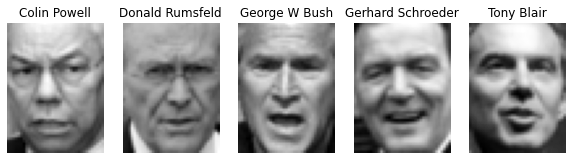

In [101]:
plot_all_type_faces(lfw_people)

**4.3** Divide the dataset into train and test set (0.7/0.3). 

Hint: use the train_test_split function.

In [38]:
# As before, get all the data set and its label to split them in train and test sets
X = lfw_people.data
y = lfw_people.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

NameError: name 'lfw_people' is not defined

In [103]:
print("Length of the training data set:", len(X_train), "( 0.7 *", lfw_people.images.shape[0], ")")

Length of the training data set: 798 ( 0.7 * 1140 )


In [104]:
print(lfw_people.images[0].shape)

(50, 37)


## 5. Compute PCA

[*class sklearn.decomposition.PCA(n_components=None, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)*](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA)

The principal components measure deviations about this mean along orthogonal axes.

**5.1** Create a PCA object, using the training set and a 150 components

In [105]:
from sklearn.decomposition import PCA

# Building the PCA with 150 components and X_train data set
pca = PCA(n_components=150, svd_solver="randomized", whiten=True).fit(X_train)

Plot the accumated variance of the components. 

**Hint:** Use the returned `explained_variance_ratio_`.

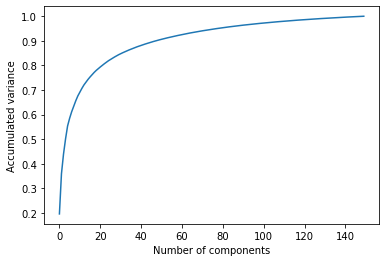

Accumulated variance of the components: 1.0


In [106]:
# We have from the correspondent variable from the PCA
eigenvalues = pca.explained_variance_ratio_
# Calculate the accumulated variance
accumulated_variance = []
cumulative_sum = 0

for value in eigenvalues:
    cumulative_sum += value
    accumulated_variance.append(cumulative_sum / sum(eigenvalues))

# Plot the accumulated variance
plt.plot(accumulated_variance)
plt.xlabel('Number of components')
plt.ylabel('Accumulated variance')
plt.show()

print("Accumulated variance of the components:", accumulated_variance[-1])

**5.2** One interesting part of PCA is that it computes the average face, which can be interesting to examine. 

Plot the average face, using the method `mean_` of the PCA object.

**Hint:** The average face need to be reshaped in order to visualize it properly

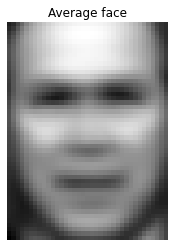

In [108]:
# Plot the average face of the PCA object we created, remember the shape to reshaped is from one image of the data set people
mean_face = pca.mean_
mean_face = mean_face.reshape(lfw_people.images[0].shape)
show_img(mean_face, "Average face")

# We can also normalize: mean_face = (pca.mean_-pca.mean_.min())/(pca.mean_.max()-pca.mean_.min())


In [109]:
print(mean_face.shape) # 50*37 = 1850

(50, 37)


**5.3** Furhtermore, we can check all the principal components (i.e. eigenfaces) considering the corresponding importance. Visualize 30 principal eigenfaces.

<img src="notebook_images/eigenfaces.png" width=500, height=500>

Note that the base components are ordered by their importance. We see that the first few components seem to primarily take care of lighting conditions; the remaining components pull out certain identifying features: the nose, eyes, eyebrows, etc...

In [110]:
print(pca.components_.shape)

(150, 1850)


In [111]:
def plot_principal_eigenfaces(pca, n_eingenfaces = 30):
    # Get the eigenfces from pca
    eigenfaces = pca.components_[:n_eigenfaces]
    # Plot them all as the example
    print("Principal eingenfaces:")
    fig, axes = plt.subplots(3, 10, figsize=(15,5), subplot_kw={'xticks':[], 'yticks':[]})           
    for i, ax in enumerate(axes.flat):
        ax.imshow(eigenfaces[i].reshape(lfw_people.images[0].shape), cmap='gray')

Principal eingenfaces:


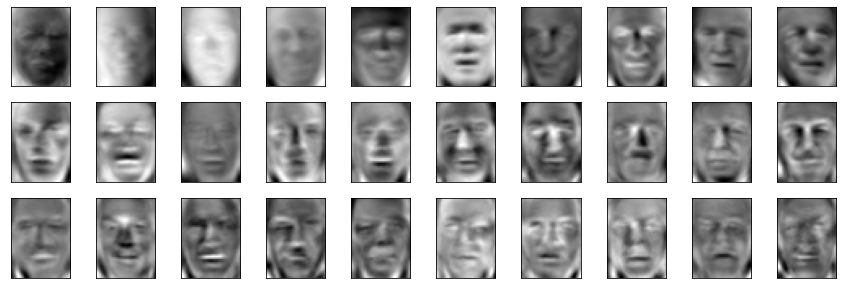

In [112]:
# For that purpose we use the components_ variable from PCA
# Visualize the 30 most important eigenfaces
n_eigenfaces = 30

plot_principal_eigenfaces(pca, n_eigenfaces)
#plt.show()

**5.4** Project both the training and test set onto the PCA basis, using the method `transform()` of the PCA object.

In [113]:
# Project the training and test sets onto the PCA basis
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Do you need to apply the same to the variable y?

> Knowing that the resulting arrays X_train_pca and X_test_pca will contain the projections of the training and test sets onto the PCA basis, respectively.
> So we don't need to project the y, we just need apply to the features. The labels aren't affected by the PCA transformation and so don't need to be projected.

**5.5**  These projected components correspond to factors in a linear combination of component images such that the combination approaches the original face. 

Choose one of the images and try to recompose from its first 10 most important corresponding eigenfaces. **Note that** we need to use the average face as the basis to agregate the rest of the components.


<img src="notebook_images/eigenfaces_image.PNG" width=300, height=300>


In [115]:
# Now we need to construct a linear combination of 10 most important eigenfaces (average face as basic)
def composite_face(index, pca, X_train_pca, lfw_people, n_eingenfaces = 10):
    '''
    function that shows the composition of the original face with n eigenfaces
        index: int that indicates the image from train data we want to composite
        lfw_people: data set of the face images
    '''
    # Get the datas from data set, factors w_i and the eingenfaces u_i
    # Our original face get from the function of PCA
    face = pca.inverse_transform(X_train_pca[index]).reshape(lfw_people.images[0].shape)
    face_weights = X_train_pca[index][:n_eingenfaces]
    # We need to normalize the eigenfaces for make the sum then to the mean face
    eigenfaces = pca.components_[:n_eingenfaces]
    eigenfaces = eigenfaces/np.linalg.norm(eigenfaces)

    # Compute the reconstruction of the original face using the average face and the first 10 principal components
    reconstructed_face = np.dot(face_weights, eigenfaces)
    reconstructed_face += pca.mean_/np.linalg.norm(pca.mean_) # Add the average face as the basis
    # Need to reshape to get the form of the image
    reconstructed_face = reconstructed_face.reshape(lfw_people.images[0].shape)
    
    show_row_of_images([face, reconstructed_face], ["Reconstructed Face from PCA", "Reconstructed face"])

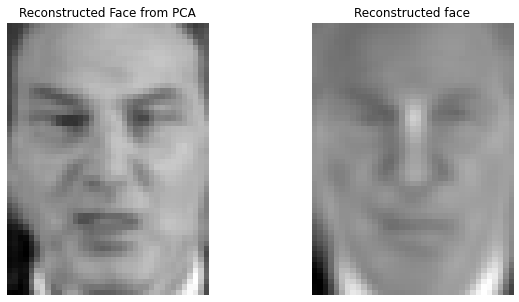

In [116]:
# Choose a random face from train data
random_index = random.randint(0, len(X_train_pca) - 1)

# And use the function to complete the image
composite_face(random_index, pca, X_train_pca, lfw_people)

## 6. Train a classifier

**6.1** Train an Adaboost classifier using the PCA features. Show the results obtained with the test set.
Use the `score` method of the Adaboost model.

In [131]:
# Having the transformed X train data set we use as before an adaboost classifier
# Create an Adaboost classifier by default
adaboost = AdaBoostClassifier()

# And use the function we have defined
score = evaluate(adaboost, X_train_pca, y_train, X_test_pca, y_test)

print(f'Test set score: {score}')

Test set score: 0.5906432748538012


**6.2** We can quantify this effectiveness using one of several measures from sklearn.metrics. First we can do the classification report, which shows the precision, recall and other measures of the “goodness” of the classification.

*sklearn.metrics.classification_report(y_true, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')*

*Please, check the parameters and returned value by ``classification_report()`` before continuing.*

Print the classification report obtained during the training of the Adaboost model.

In [133]:
# Generate a classification report for the train data with pca
y_pred = adaboost.predict(X_test_pca)

# The parameter y_true was the real y_train labels and y_pred is the label the classifier makes
print(classification_report(y_test, y_pred, target_names=lfw_people.target_names))

                   precision    recall  f1-score   support

     Colin Powell       0.63      0.44      0.52        71
  Donald Rumsfeld       0.74      0.37      0.49        38
    George W Bush       0.58      0.86      0.69       150
Gerhard Schroeder       0.47      0.22      0.30        36
       Tony Blair       0.59      0.43      0.49        47

         accuracy                           0.59       342
        macro avg       0.60      0.46      0.50       342
     weighted avg       0.60      0.59      0.56       342



Please, explaing what is:
- **accuracy (score)**: is a measure of how well a classifier performs. It is the ratio of the number of correct predictions made by the classifier to the total number of predictions made.
<center>
${accuracy}=\frac{number.of.correct.preditions}{number.of.total.predictions}$
</center>
- **precision**: is a measure of the accuracy of the classifier when it predicts the positive class. It is the ratio of the number of true positives (predictions that are actually positive) to the total number of predicted positives (predictions that are either true or false).
<center>
${precision}=\frac{True.Positive}{True.Positive + False.Positive}$
</center>
- **recall**: is a measure of the classifier's ability to find all the positive instances. It is the ratio of the number of true positives to the number of actual positive instances.
- **f1-score**: is a harmonic mean of precision and recall, with a higher score indicating a better balance between precision and recall.
<center>
${precision}=\frac{2*recall*precision}{recall+precision}$
</center>
- **support**: is the number of samples of the true response that lie in that class.
- **macro avg**: is the average of the precision, recall, and F1 score across all classes. It does not take into account the relative class sizes, so it can be affected by imbalanced class sizes.
- **weighted avg**: is the average of the precision, recall, and F1 score across all classes, with each class’s score weighted according to the number of samples in that class. This can be useful when you have imbalanced class sizes, as it gives more weight to the scores of the larger classes.

> In that case we can see in the fist column the precision from each existing class, it measures the proportion of positive predictions that were actually correct, it's between 0.67 - 0.79. It's not bad. Then the recall, it measures the proportion of positive examples that were correctly predicted, there are ups and dows. For the f1-score, returns the balance between the first two. And the support is just the number of samples of each class in the test set (so the total will be the total number of data set, in that case, 798).

**6.3** Train an Adaboost classifier, without PCA, using the training set. Show the results using the `score` method of the Adaboost model and the corresponding classification report.

In [39]:
# Without pca the training data set of faces is X_train
# Evaluate the classifier on the test data
score = evaluate(adaboost, X_train, y_train, X_test, y_test)

# Generate a classification report for the train data
y_pred = adaboost.predict(X_train)
report = classification_report(y_train, y_pred, target_names=lfw_people.target_names)

# Generate a classification report for the test data, that is the real case
y_pred2 = adaboost.predict(X_test)
report2 = classification_report(y_test, y_pred2, target_names=lfw_people.target_names)

print(f'Train set score: {score}')

print("Report train set,\n", report)
print("\nReport test set,\n", report2)

NameError: name 'adaboost' is not defined

**Questions**

In [125]:
%%time
score = evaluate(adaboost, X_train, y_train, X_test, y_test)

CPU times: user 5.08 s, sys: 20.4 ms, total: 5.1 s
Wall time: 5.13 s


In [127]:
%%time
score = evaluate(adaboost, X_train_pca, y_train, X_test_pca, y_test)

CPU times: user 619 ms, sys: 5.57 ms, total: 624 ms
Wall time: 638 ms


Does computing time change using PCA? How?

> Yes, as we can see in the two cases. We need less time using PCA, that occurs because we transformed the training data using PCA. So now we are working and making calculations in a smaller space, which can make the model more efficient and improve its performance. But using PCA can remove some important information.

Which of both (with and without PCA) does give better results?

> It depends. As we comment in the previous questions, depending on the type of data set we have, PCA can perform better because the more information was concentrated in a small dimension, but others times, it can give worst results as we remove some important dimensions. In that case, as we can see in the classification report and the score maybe nnot using PCA give better results.

How does the result change if we change the number of components in PCA?

> When the number of components change, means we are changing the dimension of information we are using. So for larger number of components we can make better matches and take higher positive classifications, but don't forget somtimes we can go for overfitting as the dimension is too big (because we have catched some not important information). So for that we need to compute for different number of components and test them all for take the betters results and model.

How does the result change if we change the number of estimators in the Adaboost?

> The number of estimators (also known as the "number of weak learners") in an AdaBoost model determines the complexity of the model. In general, increasing the number of estimators will result in a more complex model that may be able to capture more of the patterns in the data, but it may also lead to overfitting. But, In general, increasing the number of estimators will result in a more complex model that may be able to capture more of the patterns in the data, but it may also lead to overfitting. So as the previous questions we will try for different values and choose the best one for our data set.

**6.4 (Optional)** Repeat the experiment using a different number of components. 

For instance, instead of using 150 components, try using 10, 25, 50, 200, 500... at your election. These numbers are just orientative. 

- How much variance is acummulated using the different number of components.
- The result is better using... how many components? 
- Does time change using a different numbero of components?

In [140]:
n_components = [10, 50, 500]

In [141]:
# Create an Adaboost classifier by default, but using different pcas
adaboost2 = AdaBoostClassifier()

In [150]:
for i in range(len(n_components)):
    pca = PCA(n_components=n_components[i]).fit(X_train)

    # We transform into PCA dimension
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Evaluate the classifier on the test data
    score = evaluate(adaboost2, X_train_pca, y_train, X_test_pca, y_test)

    # Generate a classification report for the test data
    y_pred = adaboost2.predict(X_test_pca)
    report = classification_report(y_test, y_pred, target_names=lfw_people.target_names)

    print(f'Test set score: {score}')
    print("Report test set,\n", report)
    print("\n")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Test set score: 0.4473684210526316
Report test set,
                    precision    recall  f1-score   support

     Colin Powell       0.45      0.35      0.39        69
  Donald Rumsfeld       0.23      0.31      0.26        39
    George W Bush       0.62      0.72      0.67       149
Gerhard Schroeder       0.06      0.03      0.04        40
       Tony Blair       0.18      0.18      0.18        45

         accuracy                           0.45       342
        macro avg       0.31      0.32      0.31       342
     weighted avg       0.42      0.45      0.43       342



Test set score: 0.6345029239766082
Report test set,
                    precision    recall  f1-score   support

     Colin Powell       0.80      0.61      0.69        77
  Donald Rumsfeld       0.35      0.35      0.35        23
    George W Bush       0.64      0.84      0.73       160
Gerhard Schroeder       1.00      0.23      0.37        40
       Tony Blair       0.45      0.43      0.44        42

  

## 7. Recognize a new face example using the learned model

**7.1** Try your both models using the test set. 

Predict the labels using the Adaboost model, with and without PCA, and plot the images with the corresponding label as title.

<img src="notebook_images/prediction.png" width=300 height = 300>

In [151]:
def prediction(random_indexes, adaboost, X_train, y_train, X_test, y_test, lfw_people, pca=None):
    '''
    function that predicts the label for the random_indexes images from X_test
        random_indexes: value 0-len(X_test) for get the data we want to predict
        adaboost, pca: the instrument we are using, working in the dimension an classifier
        X_test, y_test, lfw_people: data set
    Plot the images and the titles with the prediction and the true labels.
    '''
    # Need to fit the adaboost in case of PCA or not
    adaboost.fit(X_train, y_train)
    # For each image we take the prediction and 
    predicts = adaboost.predict(X_test[random_indexes])
    
    # In case we use PCA, as we don't have the original image data, we can recover it from pca but maybe we lose information
    if pca:
        X_recovered = pca.inverse_transform(X_test)
        
    fig, axes = plt.subplots(len(random_indexes)//4, 4, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})           
    for i, ax in enumerate(axes.flat):
        ax.set_title(f'Predicted: {lfw_people.target_names[predicts[i]]} \nTrue: {lfw_people.target_names[y_test[random_indexes[i]]]}')
        if pca==None:
            ax.imshow(X_test[random_indexes[i]].reshape(lfw_people.images[0].shape), cmap='gray')
        else:
            ax.imshow(X_recovered[random_indexes[i]].reshape(lfw_people.images[0].shape), cmap='gray')
    print("Accuracy:", adaboost.score(X_test, y_test))
        

In [164]:
# Trying the prediction function for 12 random images without PCA
n_test = 12

# The most common as we now is use the training data set for the model and then use the test data set for get results
# For the first test we use the default adaboost classifier
adaboost1 = AdaBoostClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
pca = PCA(n_components=150).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [165]:
# Generate iterations number of indexes for get the images from X_test
random_indexes = random.sample(range(0, len(X_test)), n_test)

Accuracy: 0.6140350877192983
CPU times: user 5.27 s, sys: 25.8 ms, total: 5.3 s
Wall time: 5.33 s


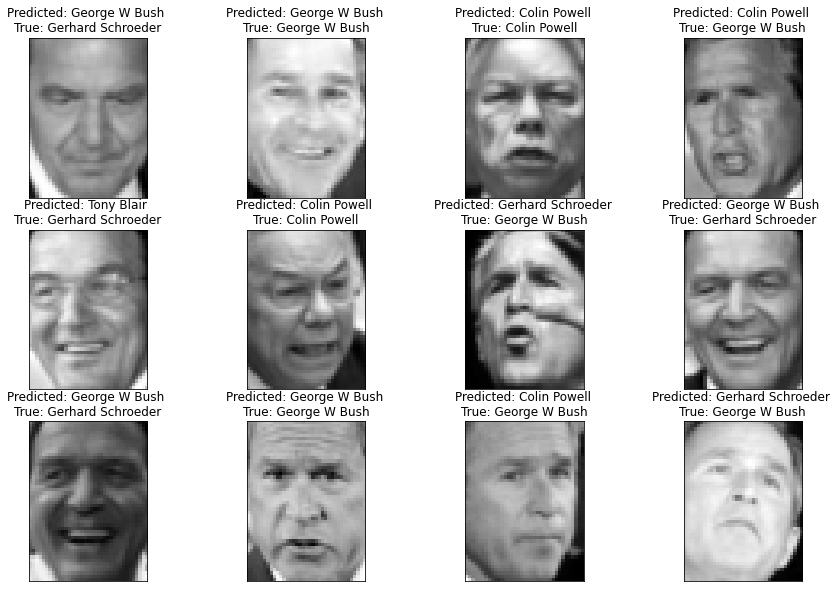

In [166]:
%%time
prediction(random_indexes, adaboost1, X_train, y_train, X_test, y_test, lfw_people)

Accuracy: 0.5584795321637427
CPU times: user 1.04 s, sys: 13.2 ms, total: 1.05 s
Wall time: 855 ms


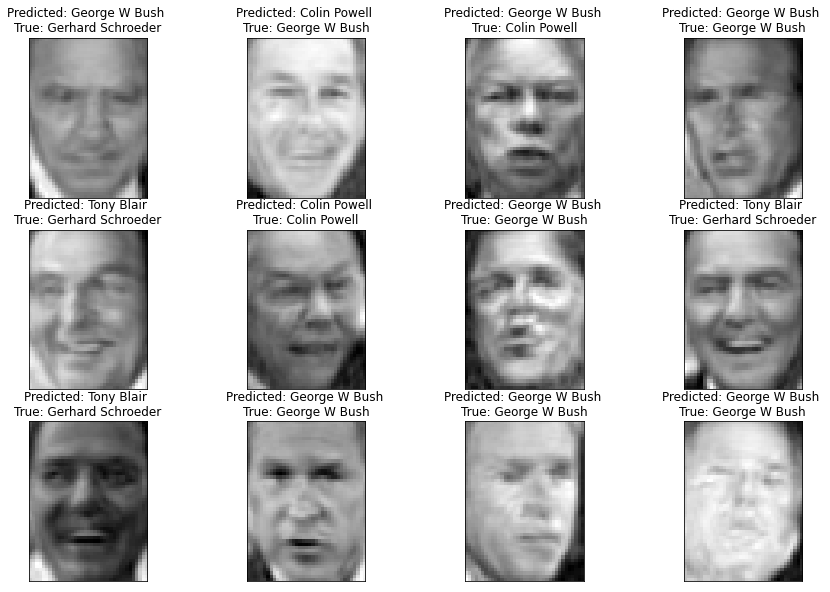

In [167]:
%%time
prediction(random_indexes, adaboost1, X_train_pca, y_train, X_test_pca, y_test, lfw_people, pca)

> In that first example, we have try to use PCA and not PCA for make a prediction. The function we defined can use for both cases just the different of the X_test_pca and a new parameter pca. We can see that the time used in the PCA is smaller, because we are working in a smaller dimension and accelerates the classification. And even the results are better in some images, but depending on the adaboost and the pca used can be different.

Which model makes the predictions betters? Try different parameters and comment their effect on the model performance.

In [168]:
# Now using different parameters
n_test2 = [12, 16, 20]

# Define the different parameters for Adaboost and PCA
param_adaboost = {'n_estimators': [50, 100, 200],'learning_rate': [0.5, 1.0, 2.0]}
param_pca = {'n_components': [50, 100, 200]}

Accuracy: 0.5906432748538012
Accuracy: 0.6228070175438597
Accuracy: 0.6345029239766082
Accuracy: 0.6403508771929824
Accuracy: 0.4853801169590643
Accuracy: 0.43567251461988304


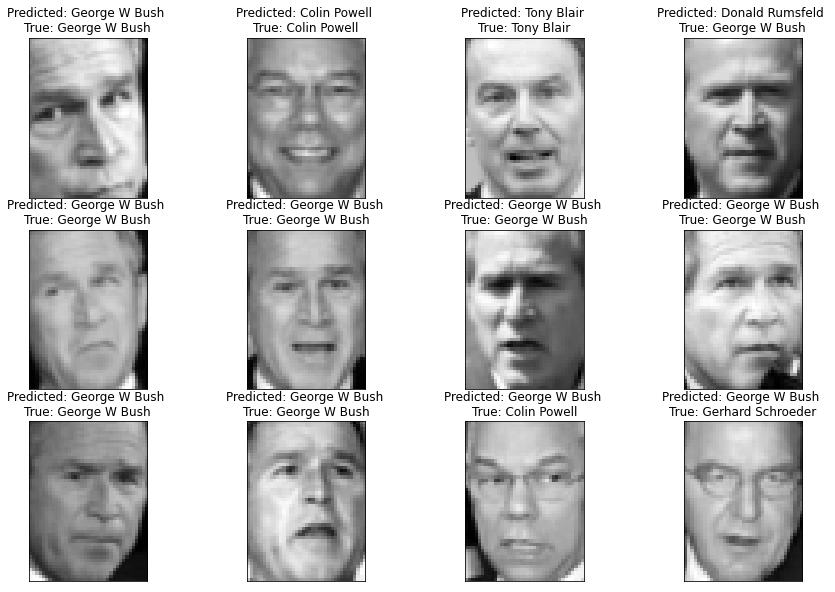

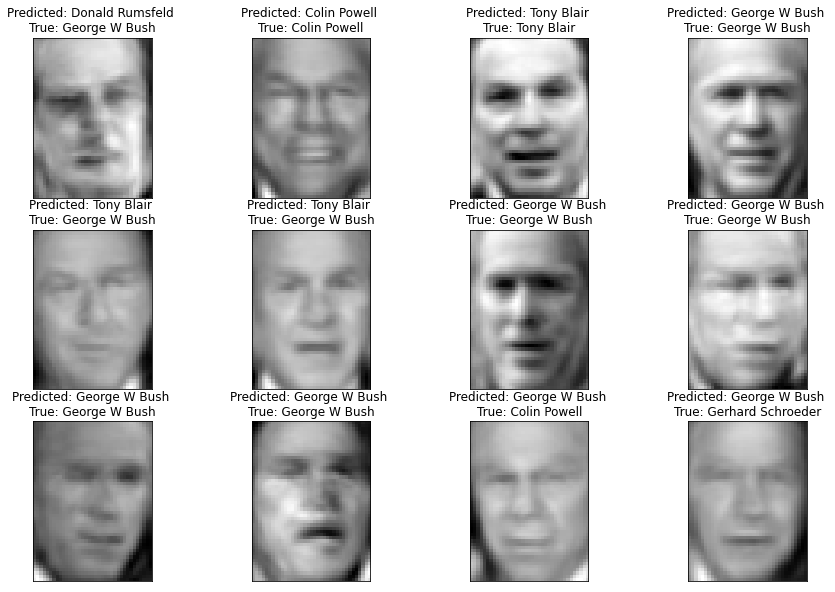

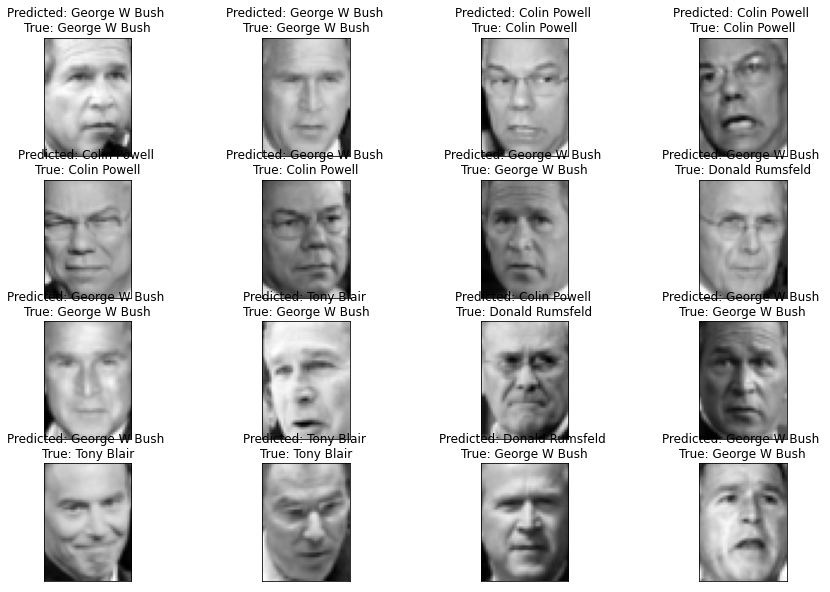

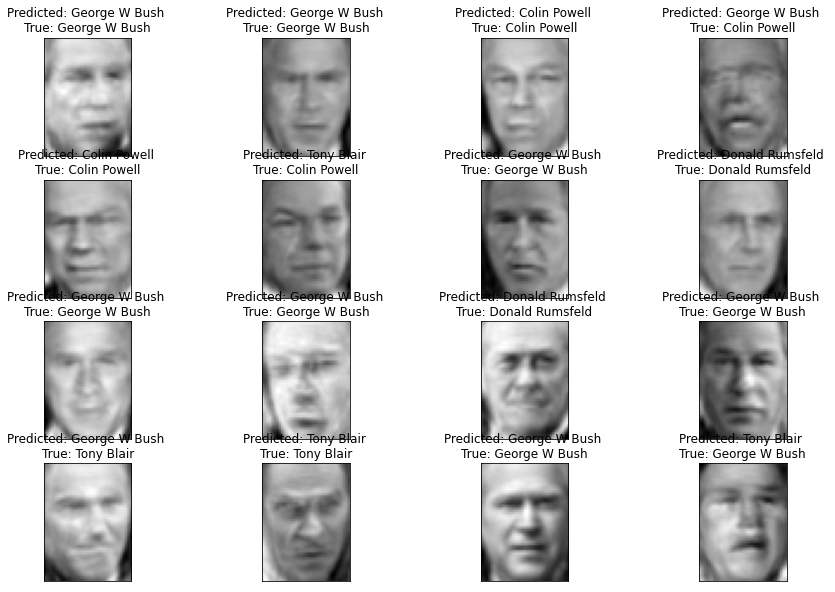

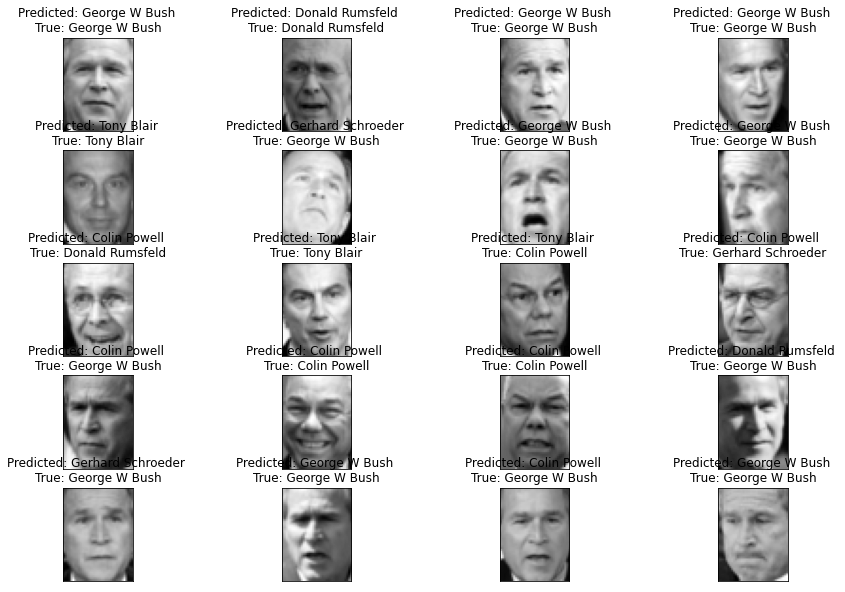

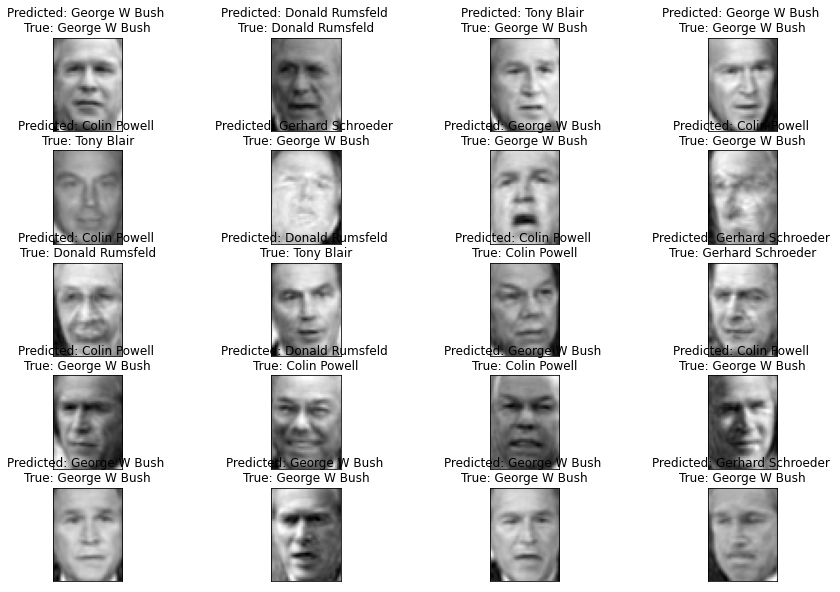

In [170]:
for i in range(len(n_test2)):
    # print("Number of images to predict:", n_test2[i])
    random_indexes2 = random.sample(range(0, len(X_test)), n_test2[i])
    # Create the adaboost without pca
    adaboost2 = AdaBoostClassifier(n_estimators=param_adaboost['n_estimators'][i], learning_rate=param_adaboost['learning_rate'][i])
    prediction(random_indexes2, adaboost2, X_train, y_train, X_test, y_test, lfw_people)
    
    # Using pca
    pca2 = PCA(n_components=param_pca['n_components'][i]).fit(X_train)
    X_train_pca2 = pca2.transform(X_train)
    X_test_pca2 = pca2.transform(X_test)
    prediction(random_indexes2, adaboost2, X_train_pca2, y_train, X_test_pca2, y_test, lfw_people, pca2)

> Seeing the results, it is usually better using PCA, as the results are similar than without using it and takes less time. But remenber the parameter n_estimators and n_components are 'inverse proportional'. That means with higher n_estimators takes better results and with not a big n_components we work better. And in each case we need not to lead to overfitting (not important information causes undesirable results).

> It's important to see the score (accuracy) from the adaboost function. In that case, using a higher n_estimator (150-200) for adaboost and a smaller n_components (50-100) for PCA. Combine that two we can get not bad results.